In [2]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt


df = pd.read_csv('datafest2018-Updated-April12.csv')

In [11]:
df

,date,companyId,jobId,country,stateProvince,city,avgOverallRating,numReviews,industry,normTitle,...,experienceRequired,estimatedSalary,salaryCurrency,jobLanguage,supervisingJob,licenseRequiredJob,educationRequirements,jobAgeDays,clicks,localClicks
0,2016-11-01,company00000,job0000000,CA,ON,Cambridge,0.0,NaN,NaN,driver,...,NaN,40600,NaN,EN,0.0,0.0,NaN,99,4,1
1,2016-11-01,company00002,job0000002,US,AZ,Peoria,0.0,NaN,NaN,customer service representative,...,NaN,22800,NaN,EN,0.0,0.0,High School,99,12,2
2,2016-11-01,company00003,job0000003,US,GA,Cartersville,3.7,71.0,NaN,host/hostess,...,NaN,22500,NaN,EN,0.0,0.0,NaN,99,15,3
3,2016-11-01,company00005,job0000005,US,AR,Malvern,5.0,46.0,NaN,data entry clerk,...,NaN,26100,NaN,EN,0.0,0.0,High School,99,25,8
4,2016-11-01,company00005,job0000006,US,AR,Augusta,5.0,46.0,NaN,data entry clerk,...,NaN,26200,NaN,EN,0.0,0.0,High School,99,33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14586030,2017-11-30,company133804,job1041301,US,NV,Reno,0.0,NaN,NaN,customer service representative,...,1.0,34300,NaN,EN,0.0,0.0,High School,0,46,12
14586031,2017-11-30,company36943,job1041302,US,TN,Jackson,3.7,70.0,NaN,kitchen team member,...,NaN,25900,NaN,EN,0.0,1.0,High School,0,17,3
14586032,2017-11-30,company36943,job1041304,US,CA,Santa Barbara,3.7,70.0,NaN,restaurant manager,...,NaN,46500,NaN,EN,1.0,0.0,High School,0,28,16
14586033,2017-11-30,company221821,job1041309,US,CA,Rancho Santa Margarita,0.0,NaN,NaN,hospitality manager,...,2.0,60800,NaN,EN,1.0,0.0,Higher Education,0,24,1


In the following chunk, I cleaned the data by selecting variables that I think is worth for following prediction, add a new column to generate the salary by making them into USD (the one who does not have any salary currency information will automatically update base on their country), and take out some na observations.

In [3]:
# Select columns and mutate 'experienceRequired' and 'count'
cleaned_df = df.drop(columns=['avgOverallRating', 'numReviews', 'descriptionCharacterLength', 'descriptionWordCount',
                              'jobLanguage', 'educationRequirements', 'supervisingJob', 'licenseRequiredJob',
                              'clicks', 'localClicks','industry'])
cleaned_df['experienceRequired'] = cleaned_df['experienceRequired'].fillna(0)
cleaned_df['count'] = np.arange(0, 14586035)

# Update 'salaryCurrency' based on country for US
ex_us = cleaned_df[(cleaned_df['salaryCurrency'].isnull()) & (cleaned_df['country'] == 'US')]['count']
cleaned_df.loc[ex_us, 'salaryCurrency'] = 'USD'

# Update 'salaryCurrency' based on country for CA
ex_ca = cleaned_df[(cleaned_df['salaryCurrency'].isnull()) & (cleaned_df['country'] == 'CA')]['count']
cleaned_df.loc[ex_ca, 'salaryCurrency'] = 'CAD'

# Update 'salaryCurrency' based on country for DE
ex_de = cleaned_df[(cleaned_df['salaryCurrency'].isnull()) & (cleaned_df['country'] == 'DE')]['count']
cleaned_df.loc[ex_de, 'salaryCurrency'] = 'DEM'

# Mutate 'salaryInUSD' based on 'salaryCurrency'
cleaned_df['salaryInUSD'] = np.where(cleaned_df['salaryCurrency'] == 'CAD',
                                     cleaned_df['estimatedSalary'] * 0.73,
                                     np.where(cleaned_df['salaryCurrency'] == 'DEM',
                                              cleaned_df['estimatedSalary'] * 0.58,
                                              cleaned_df['estimatedSalary']))

# Filter rows based on conditions
cleaned_df = cleaned_df[(cleaned_df['normTitle'] != '') &
                        (cleaned_df['stateProvince'] != '') &
                        (cleaned_df['city'] != '')]

cleaned_df.head()  # Print the resulting DataFrame



,date,companyId,jobId,country,stateProvince,city,normTitle,normTitleCategory,experienceRequired,estimatedSalary,salaryCurrency,jobAgeDays,count,salaryInUSD
0,2016-11-01,company00000,job0000000,CA,ON,Cambridge,driver,driver,0.0,40600,CAD,99,0,29638.0
1,2016-11-01,company00002,job0000002,US,AZ,Peoria,customer service representative,customer,0.0,22800,USD,99,1,22800.0
2,2016-11-01,company00003,job0000003,US,GA,Cartersville,host/hostess,food,0.0,22500,USD,99,2,22500.0
3,2016-11-01,company00005,job0000005,US,AR,Malvern,data entry clerk,admin,0.0,26100,USD,99,3,26100.0
4,2016-11-01,company00005,job0000006,US,AR,Augusta,data entry clerk,admin,0.0,26200,USD,99,4,26200.0


As we can see from the following plot that management is the largest category that has been offered from the dataset.

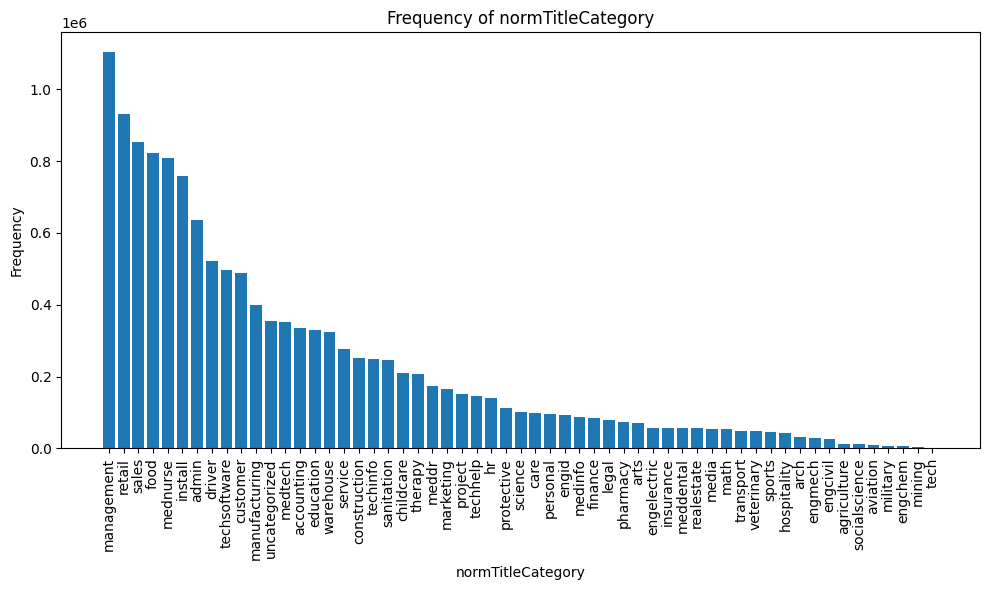

In [4]:
selected_column = cleaned_df['normTitleCategory']


frequency_table = selected_column.value_counts().reset_index()


frequency_table.columns = ['normTitleCategory', 'Freq']


frequency_table = frequency_table.sort_values('Freq', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(frequency_table['normTitleCategory'], frequency_table['Freq'])
plt.xticks(rotation=90)
plt.xlabel('normTitleCategory')
plt.ylabel('Frequency')
plt.title('Frequency of normTitleCategory')
plt.tight_layout()
plt.show()


California and Texas has the most opportunity among all of the states in US.

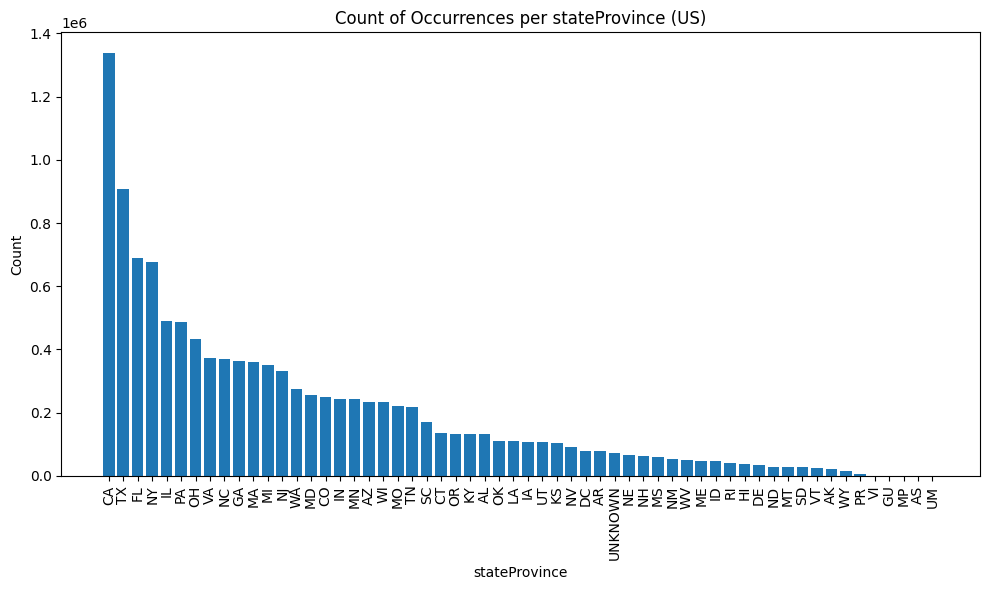

In [6]:
filtered_df = cleaned_df[cleaned_df['country'] == 'US']

state_province_counts = filtered_df['stateProvince'].value_counts().reset_index()
state_province_counts.columns = ['stateProvince', 'Count']
state_province_counts = state_province_counts.sort_values('Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(state_province_counts['stateProvince'], state_province_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('stateProvince')
plt.ylabel('Count')
plt.title('Count of Occurrences per stateProvince (US)')
plt.tight_layout()
plt.show()

Los Angeles and San Francisco has the most opportunity among all of the city in California.

            city   Count
0    Los Angeles  101464
1  San Francisco   96072
2      San Diego   74685
3       San Jose   43410
4     Sacramento   29960
5         Irvine   28520
6    Santa Clara   16090
7        Oakland   15793
8      Palo Alto   14860
9      Sunnyvale   14753


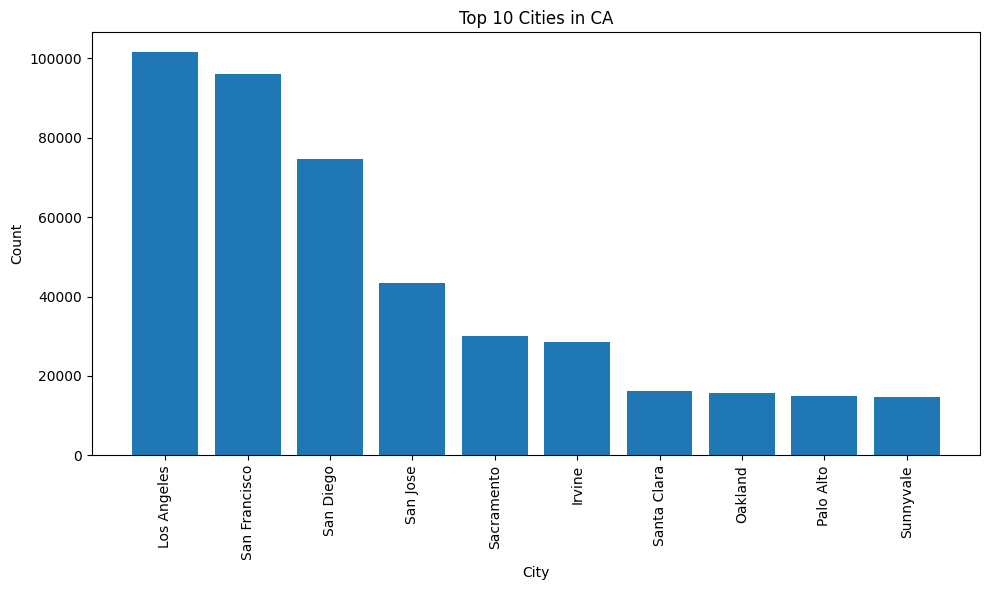

In [7]:
CA_filtered = cleaned_df[cleaned_df['stateProvince'] == 'CA']

CA_city_counts = CA_filtered['city'].value_counts().reset_index()
CA_city_counts.columns = ['city', 'Count']
CA_city_counts = CA_city_counts.sort_values('Count', ascending=False).head(10)

print(CA_city_counts)

plt.figure(figsize=(10, 6))
plt.bar(CA_city_counts['city'], CA_city_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 10 Cities in CA')
plt.tight_layout()
plt.show()


Houston and Dallas has the most opportunity among all of the city in Texas.

          city   Count
0      Houston  114431
1       Dallas   84414
2       Austin   81542
3  San Antonio   70739
4   Fort Worth   36029
5        Plano   22457
6       Irving   17173
7      El Paso   15134
8    Arlington   12585
9      Lubbock   10045


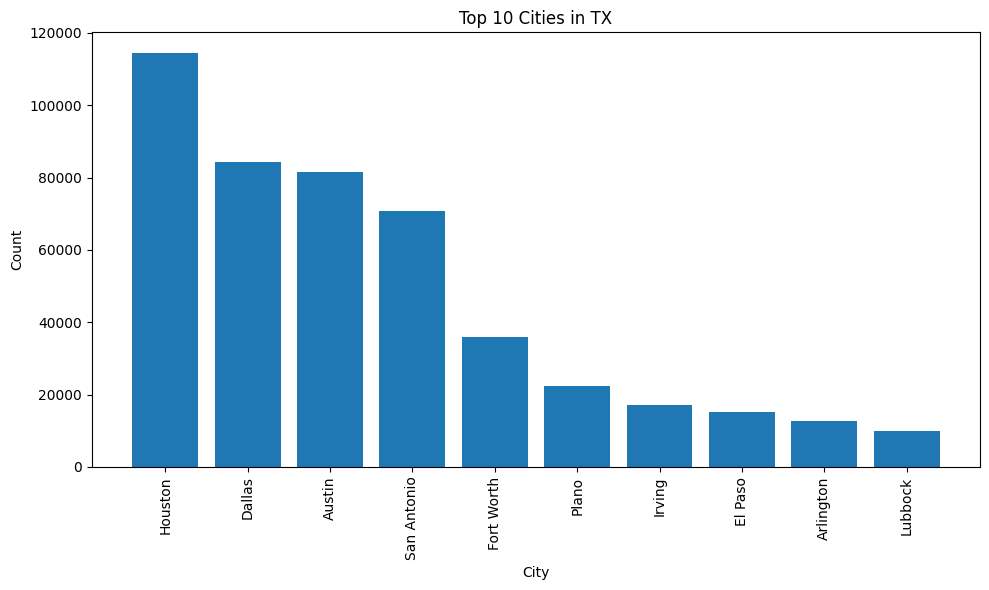

In [9]:
TX_filtered = cleaned_df[cleaned_df['stateProvince'] == 'TX']

TX_city_counts = TX_filtered['city'].value_counts().reset_index()
TX_city_counts.columns = ['city', 'Count']
TX_city_counts = TX_city_counts.sort_values('Count', ascending=False).head(10)

print(TX_city_counts)

plt.figure(figsize=(10, 6))
plt.bar(TX_city_counts['city'], TX_city_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 10 Cities in TX')
plt.tight_layout()
plt.show()

Orlando and Tampa has the most opportunity among all of the city in Florida.

               city  Count
0           Orlando  55449
1             Tampa  54771
2             Miami  48801
3      Jacksonville  42598
4   Fort Lauderdale  21316
5  Saint Petersburg  15422
6        Fort Myers  14402
7   West Palm Beach  12943
8        Boca Raton  12348
9          Sarasota  12161


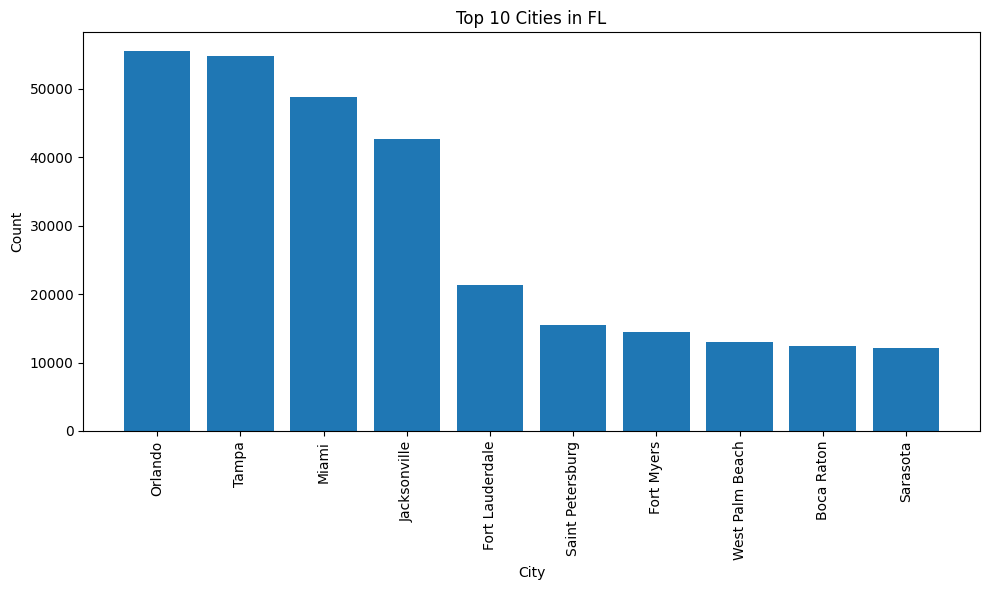

In [10]:
FL_filtered = cleaned_df[cleaned_df['stateProvince'] == 'FL']

FL_city_counts = FL_filtered['city'].value_counts().reset_index()
FL_city_counts.columns = ['city', 'Count']
FL_city_counts = FL_city_counts.sort_values('Count', ascending=False).head(10)

print(FL_city_counts)

plt.figure(figsize=(10, 6))
plt.bar(FL_city_counts['city'], FL_city_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 10 Cities in FL')
plt.tight_layout()
plt.show()

Most of the job has been offered in New York

           city   Count
0      New York  229557
1      Brooklyn   30439
2     Rochester   20981
3       Buffalo   17698
4        Albany   15535
5      Syracuse   14305
6         Bronx   14005
7     Manhattan   10152
8        Queens    6164
9  White Plains    6141


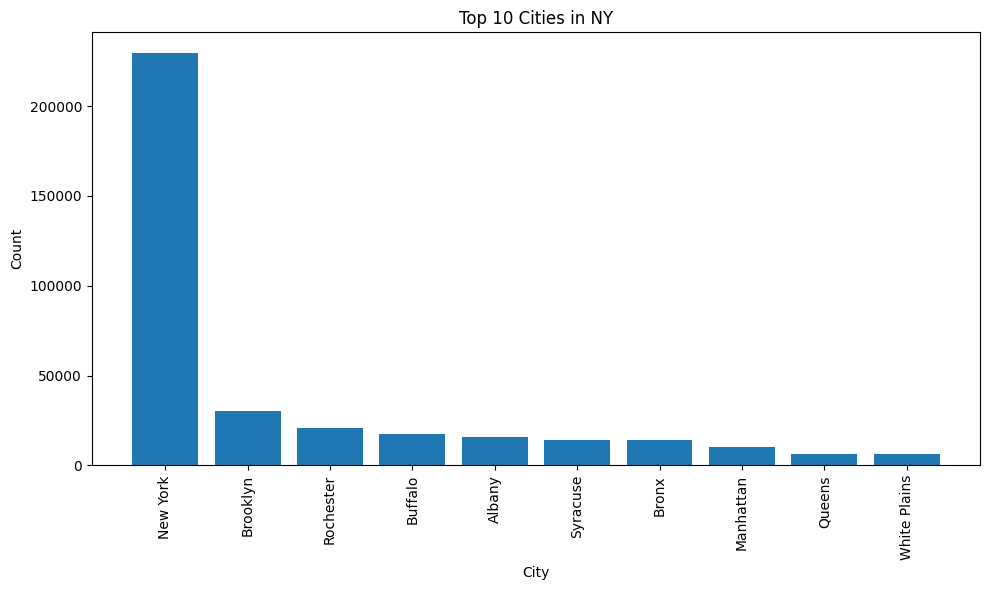

In [11]:
NY_filtered = cleaned_df[cleaned_df['stateProvince'] == 'NY']

NY_city_counts = NY_filtered['city'].value_counts().reset_index()
NY_city_counts.columns = ['city', 'Count']
NY_city_counts = NY_city_counts.sort_values('Count', ascending=False).head(10)

print(NY_city_counts)

plt.figure(figsize=(10, 6))
plt.bar(NY_city_counts['city'], NY_city_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 10 Cities in NY')
plt.tight_layout()
plt.show()

Ontario has the most opportunity among all of the states in Canada.

   stateProvince   Count
0             ON  503744
1             QC  207004
2             BC  185938
3             AB  112310
4             SK   24883
5             MB   23907
6             NS   19434
7             NB   13996
8        UNKNOWN    8719
9             NL    7205
10            PE    2316
11            YT    1234
12            NT     861
13            NU     785


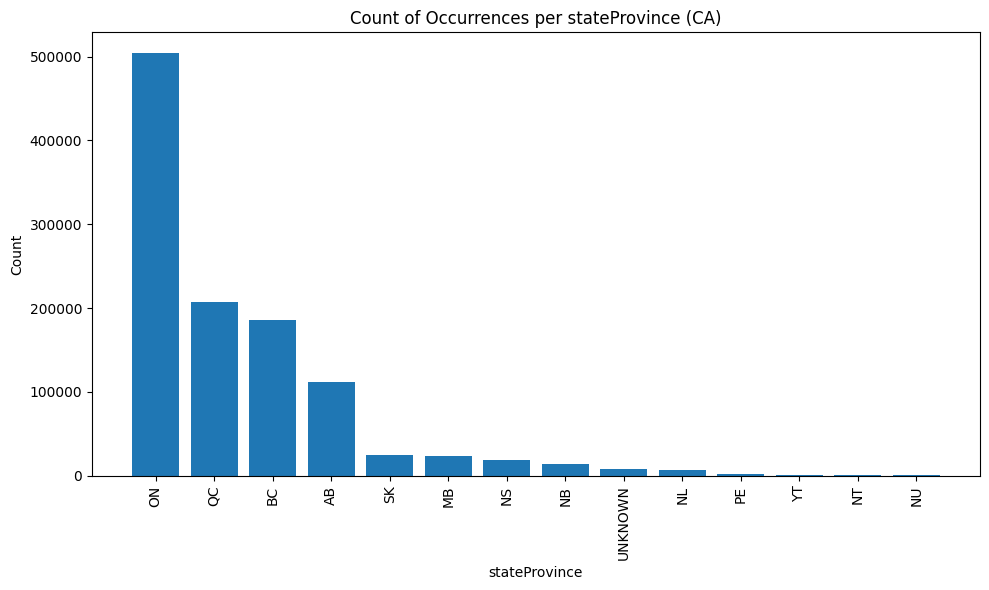

In [12]:
CA_filtered = cleaned_df[cleaned_df['country'] == 'CA']

CA_state_counts = CA_filtered['stateProvince'].value_counts().reset_index()
CA_state_counts.columns = ['stateProvince', 'Count']
CA_state_counts = CA_state_counts.sort_values('Count', ascending=False)

print(CA_state_counts)

plt.figure(figsize=(10, 6))
plt.bar(CA_state_counts['stateProvince'], CA_state_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('stateProvince')
plt.ylabel('Count')
plt.title('Count of Occurrences per stateProvince (CA)')
plt.tight_layout()
plt.show()

NW and BY has the most opportunity among all of the states in Germany.

   stateProvince   Count
0             NW  364326
1             BY  354947
2             BW  282204
3             HE  162025
4             BE  148693
5             NI  125528
6             SN   87099
7             HH   82884
8             RP   63841
9             SH   47800
10       UNKNOWN   38795
11            TH   38577
12            ST   34330
13            BB   33735
14            MV   24935
15            HB   23301
16            SL   12774
17            WA       1


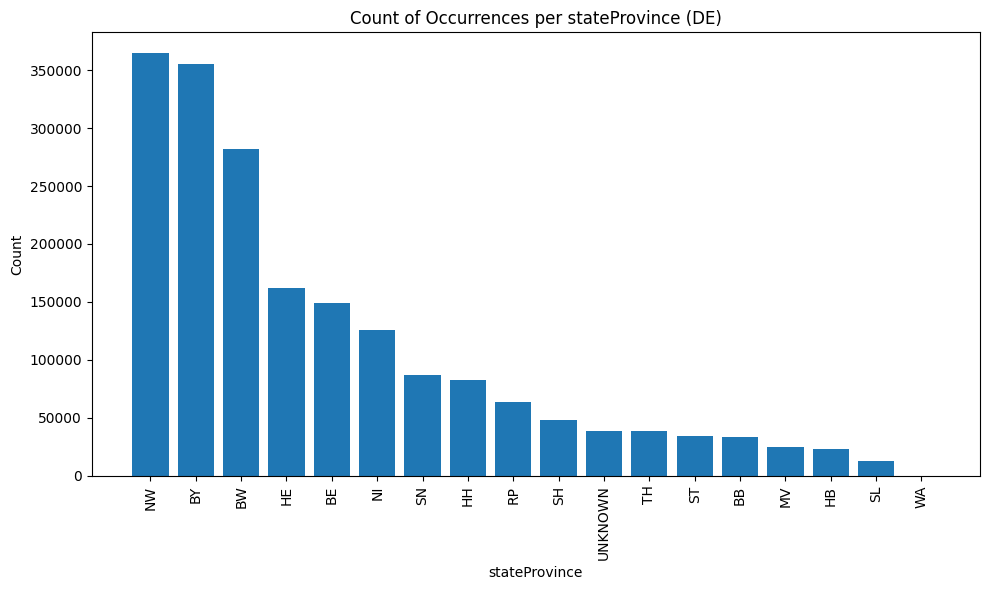

In [13]:
DE_filtered = cleaned_df[cleaned_df['country'] == 'DE']

DE_state_counts = DE_filtered['stateProvince'].value_counts().reset_index()
DE_state_counts.columns = ['stateProvince', 'Count']
DE_state_counts = DE_state_counts.sort_values('Count', ascending=False)

print(DE_state_counts)

plt.figure(figsize=(10, 6))
plt.bar(DE_state_counts['stateProvince'], DE_state_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('stateProvince')
plt.ylabel('Count')
plt.title('Count of Occurrences per stateProvince (DE)')
plt.tight_layout()
plt.show()

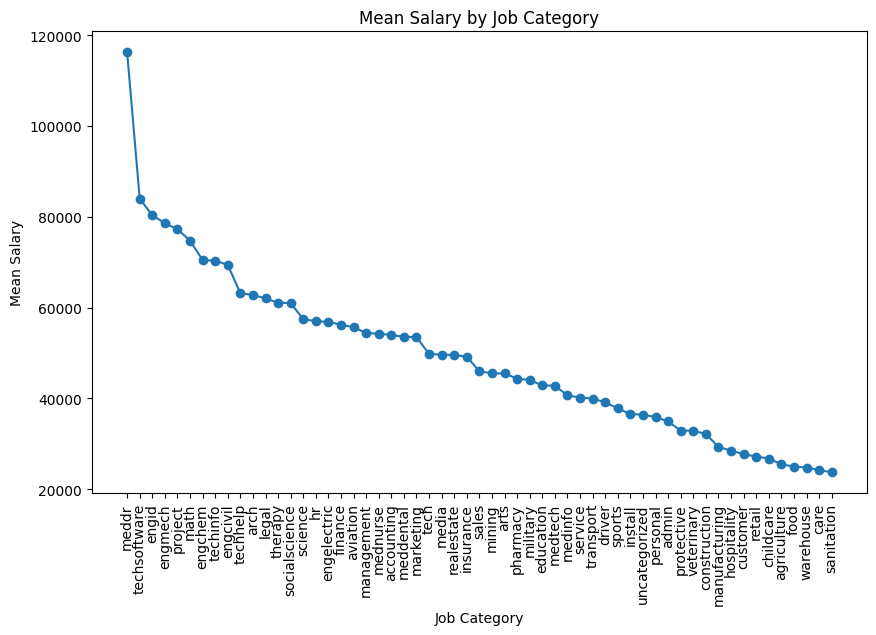

In [24]:
salary_mean = cleaned_df.groupby('normTitleCategory')['estimatedSalary'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(salary_mean.index, salary_mean.values, marker='o')

plt.xlabel('Job Category')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Job Category')

plt.xticks(rotation=90)

plt.show()

,date,companyId,jobId,country,stateProvince,city,normTitle,normTitleCategory,experienceRequired,estimatedSalary,salaryCurrency,salaryInUSD,categoryScore,salaryScore,totalScore
5479682,2017-01-05,company26274,job0222547,US,NC,Greenville,division chief,management,0.0,208100,USD,208100.0,0.502375,0.418039,0.920414
5463205,2017-01-02,company30676,job0208315,US,MA,Woburn,director of finance,management,0.0,202400,USD,202400.0,0.502375,0.406589,0.908964
5463207,2017-01-04,company30676,job0208315,US,MA,Woburn,director of finance,management,0.0,202400,USD,202400.0,0.502375,0.406589,0.908964
5463206,2017-01-03,company30676,job0208315,US,MA,Woburn,director of finance,management,0.0,202400,USD,202400.0,0.502375,0.406589,0.908964
5463201,2016-12-29,company30676,job0208315,US,MA,Woburn,director of finance,management,0.0,202400,USD,202400.0,0.502375,0.406589,0.908964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12691273,2017-09-30,company214839,job0883165,US,IN,NaN,front office mitarbeiter,hospitality,0.0,0,USD,0.0,0.018838,0.000000,0.018838
12691297,2017-10-24,company214839,job0883165,US,IN,NaN,front office mitarbeiter,hospitality,0.0,0,USD,0.0,0.018838,0.000000,0.018838
12691298,2017-10-25,company214839,job0883165,US,IN,NaN,front office mitarbeiter,hospitality,0.0,0,USD,0.0,0.018838,0.000000,0.018838
12691299,2017-10-26,company214839,job0883165,US,IN,NaN,front office mitarbeiter,hospitality,0.0,0,USD,0.0,0.018838,0.000000,0.018838


,count,mean,std,min,25%,50%,75%,max
normTitleCategory,,,,,,,,
management,905199.0,0.616807,0.064711,0.502375,0.563243,0.596790,0.659466,0.920414
sales,626014.0,0.491613,0.046956,0.388470,0.454360,0.483488,0.518442,0.772560
mednurse,739435.0,0.481426,0.044234,0.382537,0.448427,0.482979,0.507487,0.774060
retail,826298.0,0.478212,0.025062,0.450181,0.463239,0.469868,0.483528,0.776819
food,695045.0,0.425312,0.019201,0.374695,0.413466,0.419492,0.429737,0.647094
techsoftware,376550.0,0.420960,0.043940,0.226485,0.394022,0.421744,0.450068,0.592093
install,606338.0,0.420568,0.025071,0.345269,0.404530,0.416583,0.431449,0.742015
admin,472995.0,0.363611,0.036258,0.289570,0.341398,0.351844,0.373137,0.706404
meddr,143801.0,0.345460,0.107898,0.114657,0.250454,0.352302,0.451338,0.578899
